In [22]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import pandas as pd
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
header=df.columns
df.head()
df

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,2020-06-02,"SARS-CoV-2, NAA",Nasal,Negative,37,False,NaN,False,False,False,False,False,False,False,False,36.50,81.0,116.0,77.0,15.0,97.0,NaN,NaN,True,False,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,2020-04-14,Rapid COVID-19 Test,Nasopharyngeal,Negative,52,False,False,False,False,False,False,False,False,False,False,37.10,65.0,132.0,74.0,16.0,100.0,NaN,NaN,False,False,False,False,NaN,False,NaN,NaN,False,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,15,False,False,False,False,False,False,False,False,False,False,37.00,74.0,123.0,80.0,17.0,99.0,NaN,NaN,False,False,False,False,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
3,2020-04-28,Rapid COVID-19 Test,Nasopharyngeal,Negative,42,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
4,2020-06-02,"SARS-CoV-2, NAA",Nasal,Negative,24,True,NaN,False,False,False,False,False,False,False,False,36.80,61.0,125.0,70.0,15.0,99.0,NaN,NaN,True,False,NaN,NaN,NaN,False,NaN,NaN,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,2020-04-28,Rapid COVID-19 Test,Nasopharyngeal,Negative,81,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
11165,2020-06-09,SARS COV2 NAAT,Nasal,Negative,48,True,True,False,False,False,False,False,False,False,False,36.70,77.0,145.0,98.0,17.0,99.0,NaN,NaN,True,False,True,True,NaN,False,NaN,False,False,NaN,False,True,False,False,False,False,True,False,NaN,NaN,NaN,NaN,False
11166,2020-05-05,Rapid COVID-19 Test,Nasopharyngeal,Negative,59,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
11167,2020-05-12,SARS COV2 NAAT,Nasopharyngeal,Negative,55,False,False,False,False,False,False,False,False,False,False,36.75,90.0,119.0,87.0,15.0,100.0,NaN,NaN,False,False,False,False,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False


In [24]:
np.sum(df.isna())

batch_date                           0
test_name                            0
swab_type                            0
covid19_test_results                 0
age                                  0
high_risk_exposure_occupation      169
high_risk_interactions            1501
diabetes                             0
chd                                  0
htn                                  0
cancer                               0
asthma                               0
copd                                 0
autoimmune_dis                       0
smoker                               0
temperature                       4627
pulse                             4644
sys                               4618
dia                               4618
rr                                5407
sats                              4783
rapid_flu_results                11004
rapid_strep_results              11083
ctab                              5293
labored_respiration               4146
rhonchi                  

In [37]:
# remove irrelevant columns and with many NaN
np.sum(df.isna())
df_new = df.drop(columns=['swab_type', 'batch_date', 'test_name', 'rapid_flu_results','rapid_strep_results','days_since_symptom_onset', 'cough_severity', 
                     'cxr_findings', 'sob_severity', 'cxr_impression', 'cxr_label', 'cxr_link','labored_respiration','wheezes'])

# continuous and categorical columns
num_columns = ["age", "temperature", "pulse", "sys", "dia", "rr", "sats"]
cat_colums = list(set(df_new.columns.tolist()) - set(num_columns))

In [38]:
# one-hot encoding
for i in df_new.columns:
  if df_new[i].dtypes == bool:
    df_new[i] = df_new[i].astype(np.float64)
  elif df_new[i].dtype == object:
    if i != 'covid19_test_results':
      df_new[i] = df_new[i].astype(np.float64)

df_new['covid19_test_results'] = (df_new['covid19_test_results'] == 'Positive').astype(np.float64)
df_new

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,ctab,rhonchi,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,er_referral
0,0.0,37,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.50,81.0,116.0,77.0,15.0,97.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10,65.0,132.0,74.0,16.0,100.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.00,74.0,123.0,80.0,17.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,24,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80,61.0,125.0,70.0,15.0,99.0,1.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,0.0,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11165,0.0,48,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70,77.0,145.0,98.0,17.0,99.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11166,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11167,0.0,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.75,90.0,119.0,87.0,15.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# normalize numerical data
def data_normalize(x):
  return (x-min(x))/(max(x)-min(x))

for i in num_columns:
  df_new[i] = data_normalize(df_new[i])

In [40]:
# divide into positive and negative dataframes
df_positive = df_new[df_new['covid19_test_results'] == 1.0]
df_negative = df_new[df_new['covid19_test_results'] == 0.0]

# impute continuous with mean value
for i in num_columns:
  df_positive[i] = df_positive[i].fillna(df_positive[i].mean())
  df_negative[i] = df_negative[i].fillna(df_negative[i].mean())

# impute categorical with most frequent value
for i in cat_colums:
  df_positive = df_positive.apply(lambda x: x.fillna(x.value_counts().index[0]))
  df_negative = df_negative.apply(lambda x: x.fillna(x.value_counts().index[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# merge and shuffle rows
df_combined = pd.concat([df_negative, df_positive])
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

print ('Negative: ', len(df_negative))
print ('Positive: ', len(df_positive))
print ('Total: ', len(df_combined))

Negative:  10854
Positive:  315
Total:  11169


In [42]:
np.random.seed(50)

trainSet = np.random.choice(len(df_combined), round(len(df_combined)*0.70), replace=False)
valSet = np.random.choice(len(df_combined), round(len(df_combined)*0.15), replace=False)
testSet = np.random.choice(len(df_combined), round(len(df_combined)*0.15), replace=False)

trainData = df_combined.iloc[trainSet]
valData = df_combined.iloc[valSet]
testData = df_combined.iloc[testSet]

In [43]:
from torch import nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(31, 64)
        self.layer2 = nn.Linear (64,16)
        self.layer3 = nn.Linear (16,4)
        self.layer4 = nn.Linear(4, 2)
        
    def forward(self, x):
        activation1 = self.layer1(x)
        activation2 = F.sigmoid(self.layer2(activation1))
        activation3 = F.sigmoid(self.layer3(activation2))
        activation4 = self.layer4(activation3)
        return activation4

In [44]:
batch_size= 64

trainFeatures = torch.Tensor(trainData.values)
valFeatures = torch.Tensor(valData.values)
testFeatures = torch.Tensor(testData.values)

train_loader = torch.utils.data.DataLoader(trainFeatures, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(valFeatures, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(testFeatures, batch_size=batch_size, num_workers=1)

In [45]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):

    # set manual seed
    torch.manual_seed(42)
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    loss = 0

    for epoch in range(num_epochs):
        for data_2nd in train_loader:
            data = data_2nd[:,1:].to(dtype=torch.float32)
            # label = torch.sign(data_2nd[:,0]).to(dtype=torch.float32)
            label = torch.sign(data_2nd[:,0]).to(dtype=torch.long)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()

        n+=1
        # save current
        iters.append(n)
        losses.append(float(loss)/batch_size)  
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))

        print("epoch: ", epoch, end = " ")
        print("train acc: ", get_accuracy(model, train_loader), end = " ")
        print("val acc: ", get_accuracy(model, valid_loader))

    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [46]:
def get_accuracy(model,data_in):
  correct = 0
  total = 0

  for data_2nd in data_in:
     total += 1
     data = data_2nd[:,1:]
     prob = torch.argmax(model(data), dim=1)
     prob = (prob == data_2nd[:,0])
     prob = 1*prob
     prob = prob.numpy()
     correct += np.sum(prob)/len(prob)

  return correct/total

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:  0 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  1 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  2 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  3 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  4 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  5 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  6 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  7 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  8 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  9 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  10 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  11 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  12 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  13 train acc:  0.9734502032520326 val acc:  0.9688552188552189
epoch:  14 train

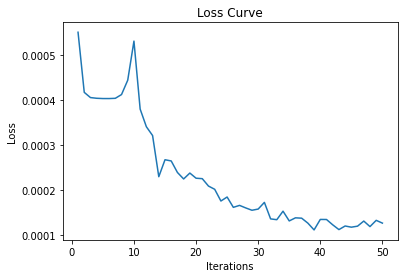

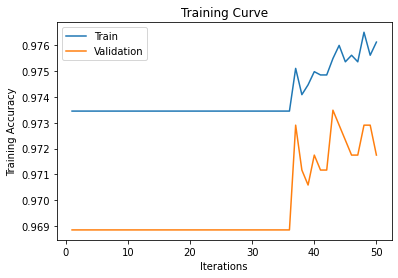

In [47]:
# CE Loss
ann = ANN()
train(ann, train_loader, valid_loader, num_epochs=50, learning_rate= 7e-3)